In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,LabelEncoder,FunctionTransformer
# from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,ParameterGrid
from sklearn.metrics import fbeta_score
from sklearn.linear_model import RidgeClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgboost
import warnings
import shap
from random import seed
from random import sample
import seaborn as sns
import pickle

In [14]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
print(df.shape)
print(df.columns)
print(df.head())

(100000, 9)
Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [15]:
y = df['diabetes'] 
X = df.drop('diabetes', axis=1)
print(y.value_counts())

diabetes
0    91500
1     8500
Name: count, dtype: int64


In [16]:
onehot_ftrs = ['gender', 'smoking_history']
std_ftrs = ['bmi', 'age', 'HbA1c_level', 'blood_glucose_level']
already_processed = ['hypertension', 'heart_disease']

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)],
        remainder='passthrough')

In [18]:
X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = 0,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state = 0,stratify=y_other)
print(X_train.shape)
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)
print(X_train_prep.shape)
print(X_val_prep.shape)
print(X_test_prep.shape)

(60000, 8)
(60000, 15)
(20000, 15)
(20000, 15)


In [19]:
print(y_train.value_counts())
print(y_test.value_counts())
print(y_val.value_counts())

diabetes
0    54900
1     5100
Name: count, dtype: int64
diabetes
0    18300
1     1700
Name: count, dtype: int64
diabetes
0    18300
1     1700
Name: count, dtype: int64


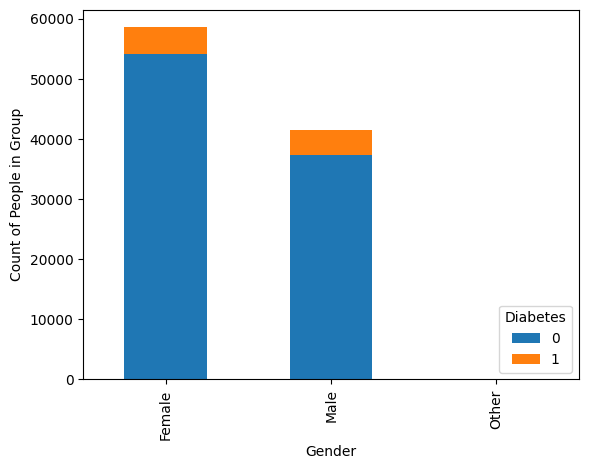

In [20]:
count_matrix = df.groupby(['gender', 'diabetes']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)
count_matrix_counts = count_matrix_norm.multiply(count_matrix.sum(axis=1), axis=0)
count_matrix_counts.plot(kind='bar', stacked=True)
plt.ylabel('Count of People in Group')
plt.xlabel('Gender')
plt.legend(title='Diabetes', loc=4)
plt.savefig(f"gender.png", bbox_inches='tight', dpi=300)
plt.show()

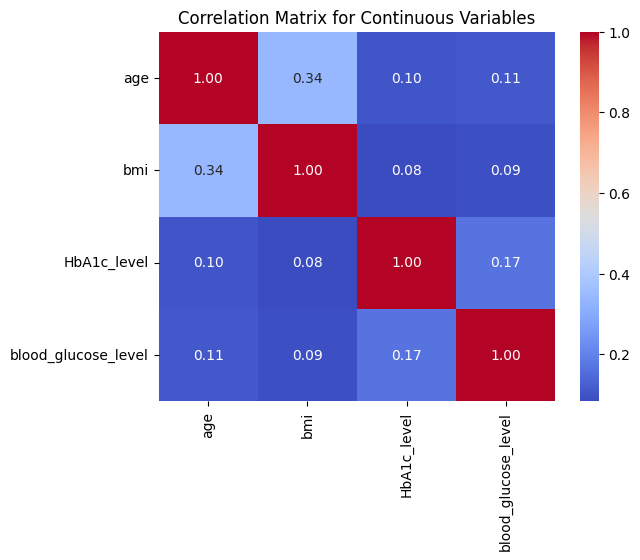

In [21]:
continuous_columns = df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
corr_matrix = continuous_columns.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Continuous Variables')
plt.savefig(f"continuous.png", bbox_inches='tight', dpi=300)
plt.show()

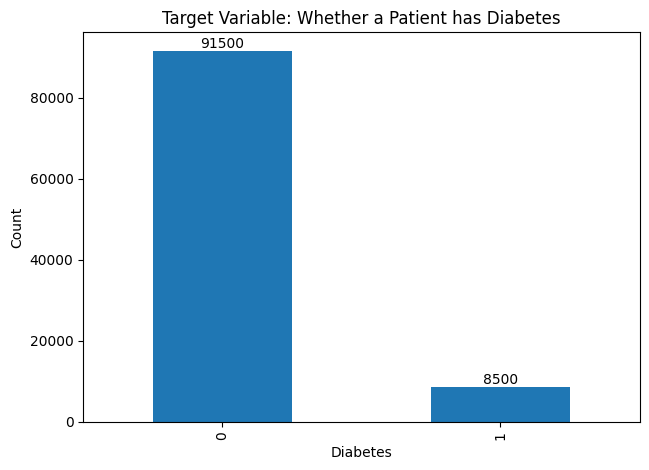

In [22]:
ax = df['diabetes'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=10,
                color='black')

plt.title("Target Variable: Whether a Patient has Diabetes")
plt.tight_layout()
plt.ylabel("Count")
plt.xlabel("Diabetes")
plt.savefig(f"target.png", bbox_inches='tight', dpi=300)
plt.show()

In [23]:
param_grid_lasso_logistic = {"C": np.logspace(-3, 3, 5)}
param_grid_ridge_logistic = {"C": np.logspace(-3, 3, 5)}
param_grid_random_forest = {"max_depth": [1, 2, 5, 10, 15], "max_features": [1, 2, 5, 10, 15]}
param_grid_svc = {"C": [0.01, 0.1, 1, 10], "gamma": [0.01, 0.1, 1, 10]}
param_grid_xgboost = {
    "learning_rate": [0.01],
    "n_estimators": [1000],
    "gamma": [0, 0.1, 0.3, 0.5],
    "max_depth": [3, 6, 10],
    "min_child_weight": [1, 5, 9],
    "colsample_bytree": [0.5, 1],              
    "subsample": [0.5, 1]
}

# Create a DataFrame for the hyperparameters
hyperparameters_table = pd.DataFrame({
    "Algorithm": ["Lasso Logistic Regression", "Ridge Logistic Regression", "Random Forest", "SVC", "XGBoost"],
    "Hyperparameters": [param_grid_lasso_logistic, param_grid_ridge_logistic, param_grid_random_forest, param_grid_svc, param_grid_xgboost]
})

# Function to convert the hyperparameters to a readable string format
def format_hyperparams(hyperparams):
    return '\n'.join([f"{key}: {value}" for key, value in hyperparams.items()])

# Apply formatting to the hyperparameters
hyperparameters_table['Hyperparameters'] = hyperparameters_table['Hyperparameters'].apply(format_hyperparams)

# Display the table
hyperparameters_table.style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})

,Algorithm,Hyperparameters
0,Lasso Logistic Regression,C: [1.00000000e-03 3.16227766e-02 1.00000000e+00 3.16227766e+01 1.00000000e+03]
1,Ridge Logistic Regression,C: [1.00000000e-03 3.16227766e-02 1.00000000e+00 3.16227766e+01 1.00000000e+03]
2,Random Forest,"max_depth: [1, 2, 5, 10, 15] max_features: [1, 2, 5, 10, 15]"
3,SVC,"C: [0.01, 0.1, 1, 10] gamma: [0.01, 0.1, 1, 10]"
4,XGBoost,"learning_rate: [0.01] n_estimators: [1000] gamma: [0, 0.1, 0.3, 0.5] max_depth: [3, 6, 10] min_child_weight: [1, 5, 9] colsample_bytree: [0.5, 1] subsample: [0.5, 1]"


**Lasso Classifier**

In [24]:
final_model_lasso = []

n_state = 5

test_scores_lasso = np.zeros(n_state)

    
for i in range(n_state):
    state = i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    C_list = np.logspace(-3, 3, 5)
    # find the best parameter set
    param_grid = {"C":C_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = LogisticRegression(**params,penalty='l1',solver='saga',max_iter=5000,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_lasso.append(best_model)
    # test the model on the test set with best parameter set
    
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_lasso[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best C is {}, and the test score is {} \n '.format(best_params,test_scores_lasso[i]))



random_states = 0
    {'C': 0.001}
   the traning score is 0.5427523896818123 and the validation score: 0.5430515571839832
    {'C': 0.03162277660168379}
   the traning score is 0.6635898715230136 and the validation score: 0.661590313319186
    {'C': 1.0}
   the traning score is 0.6660723910609893 and the validation score: 0.672718229296195
    {'C': 31.622776601683793}
   the traning score is 0.6662520729684911 and the validation score: 0.6726345890836752
    {'C': 1000.0}
   the traning score is 0.666431739977613 and the validation score: 0.6726345890836752
The best C is [{'C': 1.0}], and the test score is 0.6630109670987039 
 
random_states = 1
    {'C': 0.001}
   the traning score is 0.5408533123717192 and the validation score: 0.5530886770275564
    {'C': 0.03162277660168379}
   the traning score is 0.6608094603597602 and the validation score: 0.6798902195608783
    {'C': 1.0}
   the traning score is 0.6651166652827369 and the validation score: 0.6840796019900498
    {'C': 31.6227

**RidgeClassifier**

In [25]:
final_model_ridge = []

n_state = 5

test_scores_ridge = np.zeros(n_state)

    
for i in range(n_state):
    state = i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    C_list = np.logspace(-3, 3, 5)
    # find the best parameter set
    param_grid = {"C":C_list} 

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = LogisticRegression(**params,penalty='l2',solver='saga',max_iter=5000,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))

        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_ridge.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_ridge[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best alpha is {}, and the test score is {} \n '.format(best_params,test_scores_ridge[i]))

random_states = 0
    {'C': 0.001}
   the traning score is 0.5538922155688623 and the validation score: 0.559599636032757
    {'C': 0.03162277660168379}
   the traning score is 0.6596745328172473 and the validation score: 0.6618381618381619
    {'C': 1.0}
   the traning score is 0.6663073223318683 and the validation score: 0.6726345890836752
    {'C': 31.622776601683793}
   the traning score is 0.666431739977613 and the validation score: 0.6726345890836752
    {'C': 1000.0}
   the traning score is 0.666431739977613 and the validation score: 0.6726345890836752
The best alpha is [{'C': 1.0} {'C': 31.622776601683793} {'C': 1000.0}], and the test score is 0.6630936058830862 
 
random_states = 1
    {'C': 0.001}
   the traning score is 0.558615604805482 and the validation score: 0.5637095726717756
    {'C': 0.03162277660168379}
   the traning score is 0.6588921282798834 and the validation score: 0.6781035558328133
    {'C': 1.0}
   the traning score is 0.6652966330385686 and the validation 

**RandomForest**

In [26]:
final_model_rf = []

n_state = 5

test_scores_rf = np.zeros(n_state)

    
for i in range(n_state):
    state = i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    
    max_depth_list = [1,2,5,10,15]
    max_features_list = [1,2,5,10,15]
    # find the best parameter set
    param_grid = {"max_depth":max_depth_list,"max_features":max_features_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = RandomForestClassifier(**params,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_rf.append(best_model)
    
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_rf[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_rf[i]))

random_states = 0
    {'max_features': 1, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 2, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 5, 'max_depth': 1}
   the traning score is 0.2033858452856807 and the validation score: 0.21867529180143444
    {'max_features': 10, 'max_depth': 1}
   the traning score is 0.5036367643817501 and the validation score: 0.5274927650618259
    {'max_features': 15, 'max_depth': 1}
   the traning score is 0.5036367643817501 and the validation score: 0.5274927650618259
    {'max_features': 1, 'max_depth': 2}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 2, 'max_depth': 2}
   the traning score is 0.02899751449875725 and the validation score: 0.025603511338697878
    {'max_features': 5, 'max_depth': 2}
   the traning score is 0.6812600558895757 and the validation score: 0.6874682902080163
    {'max_features': 10, 'max_depth': 2}
 

**SVM**

In [ ]:
final_models_svm = []

n_state = 5

test_scores_svm = np.zeros(n_state)

    
for i in range(n_state):
    state = i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    C_list = [0.01,0.1,1,10]
    gamma_list = [0.01,0.1,1,10]
    # find the best parameter set
    param_grid = {"C":C_list,"gamma":gamma_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = SVC(**params,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        
            
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_models_svm.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_svm[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_svm[i]))

random_states = 0
    {'gamma': 0.01, 'C': 0.01}
   the traning score is 0.43250503693754194 and the validation score: 0.4422999597909127
    {'gamma': 0.1, 'C': 0.01}
   the traning score is 0.5789222905657109 and the validation score: 0.5772230889235569
    {'gamma': 1, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 10, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.01, 'C': 0.1}
   the traning score is 0.5920627396906106 and the validation score: 0.5874741200828157
    {'gamma': 0.1, 'C': 0.1}
   the traning score is 0.6128630348857191 and the validation score: 0.6061192873741285
    {'gamma': 1, 'C': 0.1}
   the traning score is 0.5429320515621585 and the validation score: 0.5239599789362822
    {'gamma': 10, 'C': 0.1}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.01, 'C': 1}
   the traning score is 0.6191698759092854 and the validation score: 0.6110110625160792
    {'gamma': 0.1, 

**XGBoost**

In [ ]:
final_model_xgboost = []
n_state = 5

test_scores_xgboost = np.zeros(n_state)
    
for i in range(n_state):
    state = i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    # find the best parameter set
    param_grid = {
          "learning_rate": [0.01],
          "n_estimators": [1000],
          "gamma": [0, 0.1, 0.3, 0.5],
          "max_depth": [3, 6, 10],
          "min_child_weight": [1, 5, 9],
          "colsample_bytree": [0.5, 1],              
          "subsample": [0.5, 1]
           }

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        eval_set = [(X_val_prep, y_val)]
        clf = xgboost.XGBClassifier(**params,random_state=state,use_label_encoder=False,eval_metric = "logloss")
        clf.fit(X_train_prep,y_train,early_stopping_rounds=50,verbose = False, eval_set=eval_set)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        

        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_xgboost.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_xgboost[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_xgboost[i]))

In [42]:
y_pred = np.ones(len(y))
f2 = fbeta_score(y,y_pred,beta = 2.0)
print(f2)

0.31716417910447764


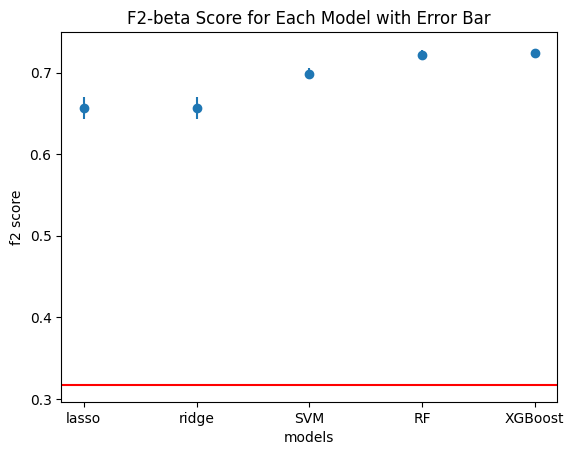

In [47]:
model_name = ["lasso","ridge","SVM", "RF","XGBoost"]

test_scores = [test_scores_lasso,test_scores_ridge,test_scores_svm,test_scores_rf,test_scores_xgboost]
mean_list = [np.mean(score) for score in test_scores]
std_list = [np.std(score) for score in test_scores]


plt.errorbar(model_name,mean_list,yerr=std_list,label = "f2 score",fmt = "o")
plt.axhline(y=f2, color='r', linestyle='-')
plt.savefig(f"plot_new.png", bbox_inches='tight', dpi=300)
plt.xlabel("models")
plt.ylabel("f2 score")
plt.title("F2-beta Score for Each Model with Error Bar")
plt.show()

In [44]:
df = pd.DataFrame({
    'Lasso Logistic Regression': test_scores_lasso,
    'Ridge Logistic Regression': test_scores_ridge,
    'SVM': test_scores_svm,
    'Random Forest': test_scores_rf,
    'XGBoost': test_scores_xgboost
})

df_summary = df.agg(['mean', 'std']).T
df_summary['F2 Beta Score (Mean ± Std)'] = df_summary['mean'].round(3).astype(str) + " ± " + df_summary['std'].round(3).astype(str)

df_summary.drop(['mean', 'std'], axis=1, inplace=True)

df_summary.reset_index(inplace=True)
df_summary.rename(columns={'index': 'Model'}, inplace=True)


baseline_row = pd.DataFrame([['Baseline', '0.317']], columns=['Model', 'F2 Beta Score (Mean ± Std)'])
df_final = pd.concat([df_summary, baseline_row], ignore_index=True)

df_final

,Model,F2 Beta Score (Mean ± Std)
0,Lasso Logistic Regression,0.656 ± 0.015
1,Ridge Logistic Regression,0.656 ± 0.015
2,SVM,0.699 ± 0.007
3,Random Forest,0.722 ± 0.006
4,XGBoost,0.724 ± 0.006
5,Baseline,0.317


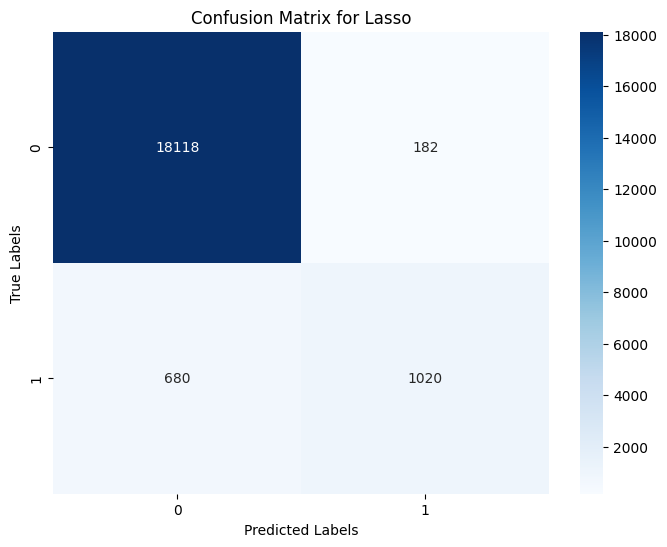

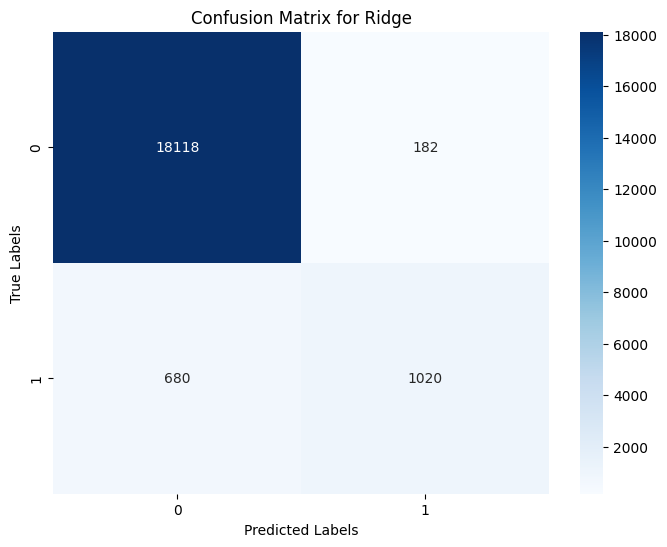

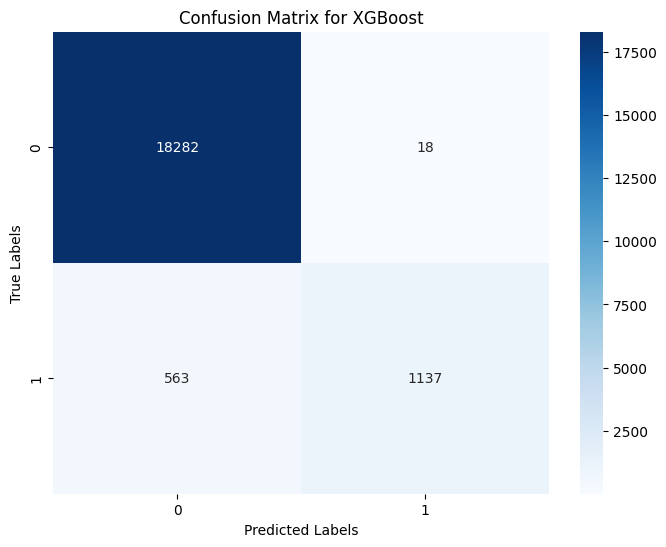

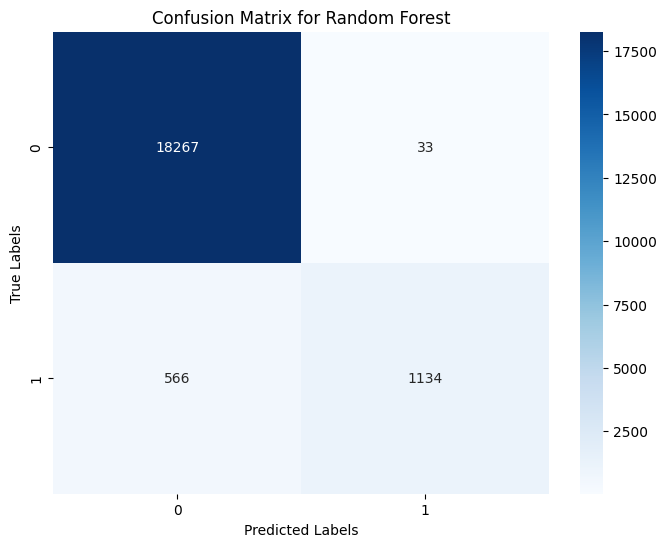

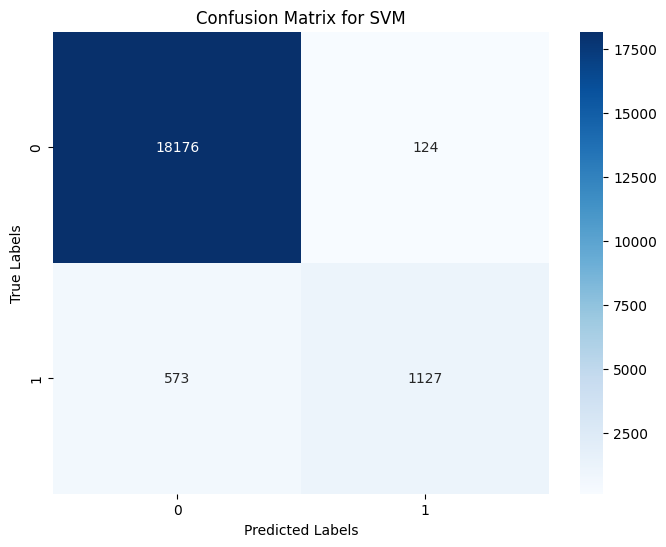

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

models = {
    "Lasso": final_model_lasso[-1],
    "Ridge": final_model_ridge[-1],
    "XGBoost": final_model_xgboost[-1],
    "Random Forest": final_model_rf[-1],
    "SVM": final_models_svm[-1]
}

for model_name, model in models.items():
    # Make predictions
    predictions = model.predict(X_test_prep)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    # Save the figure
    plt.savefig(f'{model_name}_confusion_matrix.png', bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
with open('final_model_lasso.pkl', 'wb') as file:
    pickle.dump(final_model_lasso, file)

with open('final_model_ridge.pkl', 'wb') as file:
    pickle.dump(final_model_ridge, file)

with open('final_model_rf.pkl', 'wb') as file:
    pickle.dump(final_model_rf, file)

with open('final_models_svm.pkl', 'wb') as file:
    pickle.dump(final_models_svm, file)

with open('final_model_xgboost.pkl', 'wb') as file:
    pickle.dump(final_model_xgboost, file)

**Global Feature Importance**

In [50]:
models = final_model_xgboost

In [51]:
feature_names = []

onehot_features = preprocessor.named_transformers_['onehot'].get_feature_names_out(onehot_ftrs)
feature_names.extend(onehot_features)
feature_names.extend(std_ftrs)
feature_names.extend(already_processed)

print(feature_names)

['gender_Female', 'gender_Male', 'gender_Other', 'smoking_history_No Info', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current', 'bmi', 'age', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease']


In [52]:
# Initialize an empty list to collect DataFrames
feature_importances = []

# Assuming 'models' is a list of trained XGBoost models
for model in models:
    model.get_booster().feature_names = feature_names
    # Convert the feature importance dictionary to a DataFrame and add to the list
    model_feature_importance = pd.DataFrame(model.get_booster().get_score(importance_type="gain"), index=[0])
    feature_importances.append(model_feature_importance)

# Concatenate all DataFrames in the list
feature_importance = pd.concat(feature_importances, ignore_index=True)

# Replace NaN importance with 0 according to the XGBoost documentation
feature_importance.fillna(0, inplace=True)
feature_importance

,gender_Female,gender_Male,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,bmi,age,HbA1c_level,blood_glucose_level,hypertension,heart_disease
0,3.221976,5.911772,10.437930,3.909819,3.795160,3.661935,2.802535,3.313577,7.380500,13.030894,156.489685,74.658966,14.776050,13.162873
1,3.429210,3.094045,5.516248,1.780209,2.202507,2.824719,1.502923,2.322310,4.934561,10.877845,128.779236,57.466953,9.054413,7.878701
2,2.606533,3.274377,4.151510,2.538997,2.896528,2.683112,2.408882,2.534858,4.008229,6.117669,67.756927,30.063732,4.809969,6.545962
3,1.298160,1.495664,6.121709,1.401773,1.564550,2.334165,1.209610,1.250186,4.460630,8.120657,80.791603,51.691261,18.427242,16.179863
4,3.045507,3.627833,5.181638,2.878226,3.415490,2.959727,2.651701,2.907629,4.771726,7.855696,96.849319,41.717079,8.046285,7.885644


In [53]:
importance = feature_importance.mean().sort_values(ascending= False)
features = importance.index.tolist()
error = [np.std(feature_importance[feature]) for feature in features]

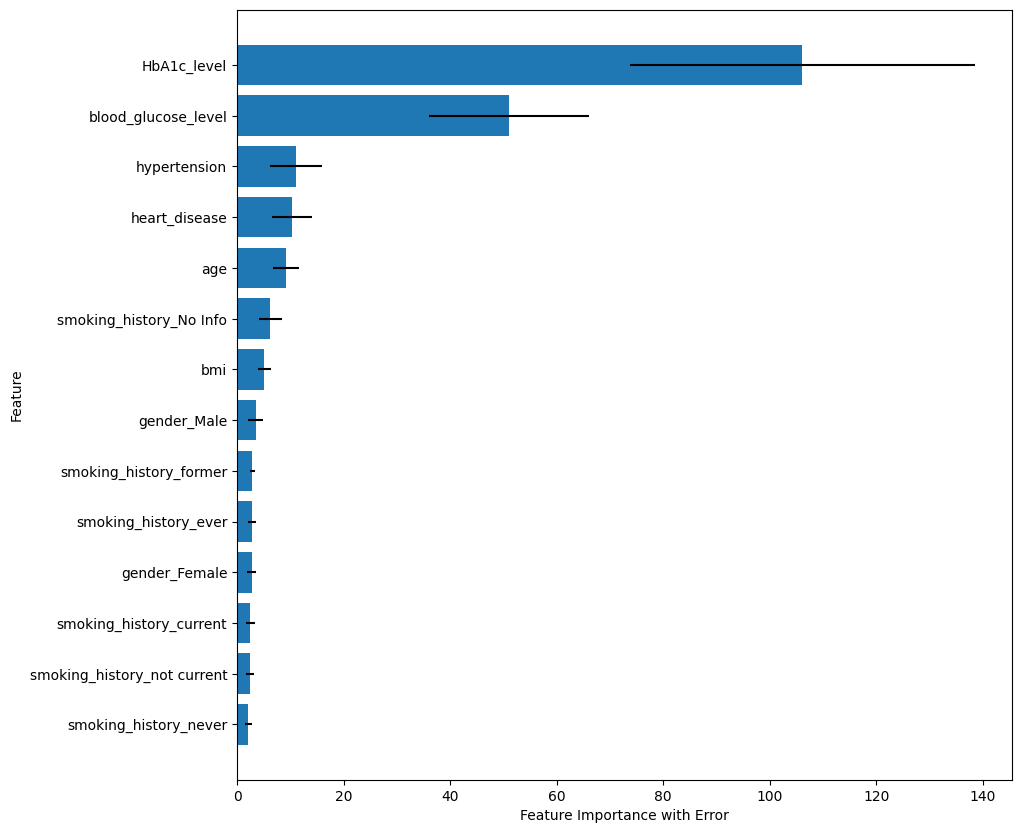

In [54]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()
ax.barh(features,importance, xerr=error, align='center')
ax.invert_yaxis() 
ax.set_xlabel('Feature Importance with Error')
plt.savefig(f'global.png', bbox_inches='tight', dpi=300)
ax.set_ylabel('Feature')
plt.show()

**Local Feature Importance**

In [ ]:
explainer = shap.TreeExplainer(final_model_xgboost[-1]) 
shap_values = explainer.shap_values(X_test_prep)  

[14:57:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
seed(1)
index_neg = sample(np.where(y_test == 0)[0].tolist(),1)

shap.force_plot(explainer.expected_value, shap_values[index_neg,:], features = X_test_prep[index_neg,:],feature_names = feature_names,
                        show = False,matplotlib=True,figsize=(40,3))
fig_neg = plt.gcf()

In [ ]:
index_pos = sample(np.where(y_test == 1)[0].tolist(),1)
shap.force_plot(explainer.expected_value, shap_values[index_pos,:], features = X_test_prep[index_pos,:],feature_names = feature_names,
               show = False,matplotlib=True,figsize=(40,3))
fig_neg = plt.gcf()

In [ ]:
for ftr in feature_names:
    indx = np.argwhere(np.array(feature_names) == ftr)
    plt.scatter(X_test_prep[:, indx], shap_values[:, indx])
    plt.ylabel('SHAP value')
    plt.xlabel(ftr)
    plt.savefig(f"{ftr}_shap_plot.png", bbox_inches='tight', dpi=300)
    plt.show()